In [11]:
import time
t1 = time.time()

In [12]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

## Use decision tree as a rough way for splitting based on that feature
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#### Load the PSD Data and take a single region (Central)

In [13]:
data_type = 'Wake'
df = joblib.load('Wake' + '_psd_normalised_data.pkl')

single_region_df = df[[col for col in df.columns if col.endswith('_Central')]]
frequency_vals  = np.arange(0.5,40.125, 0.125)
single_region_df.columns = frequency_vals

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

groups = pd.Series(paths['s_p_id'])
s_class_list = pd.Series(paths['s_class_list'])
y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})

#### Set the window width in hz and window slide in hz

In [14]:
window_width_hz = 3
window_len = (window_width_hz/0.125)+1
assert window_len%1 == 0
window_len = int(window_len)

window_slide_hz = 0.5 
window_slide_len = window_slide_hz/0.125 
assert window_slide_len%1 == 0
window_slide_len = int(window_slide_len)

#### Calculate all band values and store in dataframe calculated_df

In [15]:
# Start of the window is the middle_freq value minus window_width_hz/2 
# End of the window is the middle freq value plus window_width_hz/2
window_len

middle_freq = []
final_cols = []

i = 0
while i < len(frequency_vals) - window_len:
    middle_freq.append( frequency_vals[i:i+window_len].mean() )
    band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
    
    final_cols.append(band_vals)
    
    # scaled_psd.append( psd_values[i:i+factor].mean() )
    i+= window_slide_len

calculated_df = pd.DataFrame(final_cols).T
calculated_df.columns = middle_freq

calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]

In [16]:
calculated_df.head(3)

,2.0_width_3,2.5_width_3,3.0_width_3,3.5_width_3,4.0_width_3,4.5_width_3,5.0_width_3,5.5_width_3,6.0_width_3,6.5_width_3,...,33.5_width_3,34.0_width_3,34.5_width_3,35.0_width_3,35.5_width_3,36.0_width_3,36.5_width_3,37.0_width_3,37.5_width_3,38.0_width_3
0,0.005054,0.004244,0.003319,0.002832,0.002673,0.002595,0.002990,0.006028,0.012796,0.014166,...,0.000412,0.000405,0.000389,0.000375,0.000353,0.000330,0.000298,0.000257,0.000225,0.000201
1,0.007785,0.005690,0.004934,0.004599,0.004427,0.004366,0.005352,0.010822,0.019879,0.022397,...,0.000104,0.000102,0.000099,0.000097,0.000095,0.000091,0.000090,0.000088,0.000087,0.000085
2,0.012496,0.010247,0.007398,0.005944,0.005293,0.004890,0.004658,0.004788,0.005148,0.006142,...,0.000208,0.000202,0.000197,0.000187,0.000183,0.000173,0.000170,0.000167,0.000160,0.000156


#### Calculate Information Gain Based on features

In [17]:
#1.Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
expt_num = 2
X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)


#2.Calculate a score for each feature (Band) -> How well does a decision tree of depth 1 split based on only that feature
scores_dict = {}
for col in X_expt.columns:
    DT = DecisionTreeClassifier(max_depth=1, random_state = 5)
    DT.fit(X_expt[[col]], y_expt)
    score = accuracy_score( DT.predict(X_expt[[col]]), y_expt)
    scores_dict[col] = score

#3.Create scores dataframe -> df_results
df_results = pd.DataFrame(list(scores_dict.items()), columns=['Index', 'Score'])
df_results.set_index('Index', inplace=True)
df_results = df_results.sort_values(by = 'Score' , ascending  = False)
df_results.head(10)

,Score
Index,
3.5_width_3,0.684211
4.5_width_3,0.684211
12.0_width_3,0.657895
10.5_width_3,0.657895
28.5_width_3,0.631579
12.5_width_3,0.631579
2.5_width_3,0.631579
27.0_width_3,0.631579
27.5_width_3,0.631579


#### Do a test plot to show the effectiveness of the algorithm

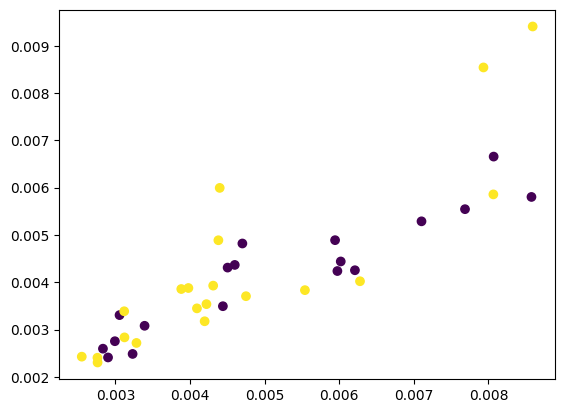

In [18]:
plt.scatter(X_expt[df_results.index[0]] , X_expt[df_results.index[1]]  , c = y_expt.values)

In [19]:
t2 = time.time()

In [20]:
t2-t1

0.6009171009063721